In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf 

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    TimeSeriesSplit
)

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

SEED = 42

In [2]:
file_path = r'C:\Users\matti\OneDrive - Scientific Network South Tyrol\UNIBZ\Laurea Magistrale\Econometria\Project\Python\Econometrics\EMM_EPMR_PTE_NUS_DPGm.xls'

# Read the Excel file into a pandas DataFrame, skip the first two rows and use the third row as header
df = pd.read_excel(file_path, skiprows=3, header=None, names=['DATE', 'Gasoline_Price'])
# Convert the 'Date' column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'])
df['DATE'] = df['DATE'].dt.to_period('M').dt.to_timestamp()

# Change the date format
df['DATE'] = df['DATE'].dt.strftime('%Y-%m-%d')

# Set the 'Date' column as the DataFrame index
df.set_index('DATE', inplace=True)

# Filter the DataFrame based on the specified start and end dates
start_date = "1997-01-01"
end_date = "2023-05-01"
df_gasoline = df.loc[start_date:end_date]
df_gasoline.reset_index(inplace=True)

# Now df_gasoline has the 'DATE' column in the desired format
df_gasoline

,DATE,Gasoline_Price
0,1997-01-01,1.236
1,1997-02-01,1.230
2,1997-03-01,1.205
3,1997-04-01,1.199
4,1997-05-01,1.200
...,...,...
312,2023-01-01,3.339
313,2023-02-01,3.389
314,2023-03-01,3.422
315,2023-04-01,3.603


In [3]:
df_uranium = pd.read_csv(r"C:\Users\matti\OneDrive - Scientific Network South Tyrol\UNIBZ\Laurea Magistrale\Econometria\Project\Python\Econometrics\PURANUSDM.csv") # Uranium Price
df_fed_rate = pd.read_csv(r"C:\Users\matti\OneDrive - Scientific Network South Tyrol\UNIBZ\Laurea Magistrale\Econometria\Project\Python\Econometrics\FEDFUNDS.csv") # Fed Rate
df_oil = pd.read_csv(r"C:\Users\matti\OneDrive - Scientific Network South Tyrol\UNIBZ\Laurea Magistrale\Econometria\Project\Python\Econometrics\POILBREUSDM.csv") # Oil
df_coal = pd.read_csv(r"C:\Users\matti\OneDrive - Scientific Network South Tyrol\UNIBZ\Laurea Magistrale\Econometria\Project\Python\Econometrics\PCOALAUUSDM.csv") # Coal
df_cpi = pd.read_csv(r"C:\Users\matti\OneDrive - Scientific Network South Tyrol\UNIBZ\Laurea Magistrale\Econometria\Project\Python\Econometrics\CPIAUCSL.csv") # CPI
df_gdp= pd.read_csv(r"C:\Users\matti\OneDrive - Scientific Network South Tyrol\UNIBZ\Laurea Magistrale\Econometria\Project\Python\Econometrics\USALORSGPNOSTSAM.csv")#GDP
df_electricity_price= pd.read_csv(r"C:\Users\matti\OneDrive - Scientific Network South Tyrol\UNIBZ\Laurea Magistrale\Econometria\Project\Python\Econometrics\APU000072610.csv")#electricity price
df_natural_gas_price = pd.read_csv(r"C:\Users\matti\OneDrive - Scientific Network South Tyrol\UNIBZ\Laurea Magistrale\Econometria\Project\Python\Econometrics\MHHNGSP.csv")#natural gas price

In [4]:
dfs_to_join = [df_uranium, df_fed_rate, df_oil, df_coal, df_cpi, df_gdp, df_electricity_price, df_natural_gas_price,df_gasoline]

# Perform inner join on 'DATE' column
merged_df = dfs_to_join[0]  # Start with the first DataFrame
for df in dfs_to_join[1:]:
    merged_df = merged_df.merge(df, on='DATE', how='inner')

# The resulting merged_df will contain all the columns from the DataFrames joined on 'DATE'.
merged_df

merged_df = merged_df.rename(columns={
    'DATE': 'Date',
    'PURANUSDM': 'uranium',
    'FEDFUNDS': 'fed_rate',
    'POILBREUSDM': 'brent',
    'PCOALAUUSDM': 'coal',
    'CPIAUCSL': 'cpi',
    'APU000072610': 'electricity_price',
    'USALORSGPNOSTSAM': 'gdp',
    'MHHNGSP': 'natural_gas_price'
})
merged_df

,Date,uranium,fed_rate,brent,coal,cpi,gdp,electricity_price,natural_gas_price,Gasoline_Price
0,1997-01-01,14.487500,5.25,23.605652,35.230000,159.400,99.556129,0.092,3.45,1.236
1,1997-02-01,13.810000,5.19,20.920500,34.600000,159.700,99.582127,0.092,2.15,1.230
2,1997-03-01,13.620000,5.39,19.559524,34.500000,159.800,99.643634,0.093,1.89,1.205
3,1997-04-01,12.825000,5.51,17.775455,35.400000,159.900,99.730817,0.092,2.03,1.199
4,1997-05-01,11.827778,5.50,19.245455,35.730000,159.900,99.826738,0.093,2.25,1.200
...,...,...,...,...,...,...,...,...,...,...
312,2023-01-01,40.063400,4.33,84.081818,404.535204,300.536,99.860089,0.168,3.27,3.339
313,2023-02-01,41.314371,4.57,83.632500,244.205357,301.648,99.885841,0.168,2.38,3.389
314,2023-03-01,40.741523,4.65,79.256522,195.999224,301.808,99.906923,0.166,2.31,3.422
315,2023-04-01,41.762017,4.83,83.536000,200.676190,302.918,99.925322,0.165,2.16,3.603


In [5]:
ticker_symbol = "DX-Y.NYB"  # Replace with the symbol of the stock you're interested in

ticker = yf.Ticker(ticker_symbol)

start_date = "1997-01-01"
end_date = "2023-05-01"

historical_data = ticker.history(start=start_date, end=end_date, interval="1mo")

# Extract the 'Close' prices
df_usd_index = historical_data[['Close']].copy()

# Reset the index to use the default integer index
df_usd_index.reset_index(inplace=True)

# Convert the 'Date' column to the desired format "YYYY-MM-DD"
df_usd_index['Date'] = df_usd_index['Date'].dt.strftime('%Y-%m-%d')
df_usd_index.rename(columns={'Close': 'close_USD_index'}, inplace=True)

# Display the modified df_usd_index
df_usd_index

,Date,close_USD_index
0,1997-01-01,93.040001
1,1997-02-01,94.889999
2,1997-03-01,94.720001
3,1997-04-01,97.180000
4,1997-05-01,94.849998
...,...,...
311,2022-12-01,103.519997
312,2023-01-01,102.099998
313,2023-02-01,104.870003
314,2023-03-01,102.510002


In [6]:
# Merge df_usd_index with merged_df on 'DATE' and 'Date' columns
result_df = merged_df.merge(df_usd_index, on='Date', how='inner')

# Display the merged DataFrame
result_df

,Date,uranium,fed_rate,brent,coal,cpi,gdp,electricity_price,natural_gas_price,Gasoline_Price,close_USD_index
0,1997-01-01,14.487500,5.25,23.605652,35.230000,159.400,99.556129,0.092,3.45,1.236,93.040001
1,1997-02-01,13.810000,5.19,20.920500,34.600000,159.700,99.582127,0.092,2.15,1.230,94.889999
2,1997-03-01,13.620000,5.39,19.559524,34.500000,159.800,99.643634,0.093,1.89,1.205,94.720001
3,1997-04-01,12.825000,5.51,17.775455,35.400000,159.900,99.730817,0.092,2.03,1.199,97.180000
4,1997-05-01,11.827778,5.50,19.245455,35.730000,159.900,99.826738,0.093,2.25,1.200,94.849998
...,...,...,...,...,...,...,...,...,...,...,...
311,2022-12-01,39.178244,4.10,81.503182,427.686964,298.990,99.828562,0.165,5.53,3.210,103.519997
312,2023-01-01,40.063400,4.33,84.081818,404.535204,300.536,99.860089,0.168,3.27,3.339,102.099998
313,2023-02-01,41.314371,4.57,83.632500,244.205357,301.648,99.885841,0.168,2.38,3.389,104.870003
314,2023-03-01,40.741523,4.65,79.256522,195.999224,301.808,99.906923,0.166,2.31,3.422,102.510002


In [7]:
#^GSPC  S&P 500
#it also includes : Renewable Energy Generation Index (REGI)
ticker_symbol = "^GSPC"  # Replace with the symbol of the stock you're interested in

ticker = yf.Ticker(ticker_symbol)

start_date = "1997-01-01"
end_date = "2023-05-01"

historical_data = ticker.history(start=start_date, end=end_date, interval="1mo")

df_sp500 = historical_data[['Close']].copy()
# Reset the index to use the default integer index
df_sp500.reset_index(inplace=True)
# Convert the 'Date' column to the desired format "YYYY-MM-DD"
df_sp500['Date'] = df_sp500['Date'].dt.strftime('%Y-%m-%d')

df_sp500.rename(columns={'Close': 'close_sp500'}, inplace=True)
df_sp500

,Date,close_sp500
0,1997-01-01,786.159973
1,1997-02-01,790.820007
2,1997-03-01,757.119995
3,1997-04-01,801.340027
4,1997-05-01,848.280029
...,...,...
311,2022-12-01,3839.500000
312,2023-01-01,4076.600098
313,2023-02-01,3970.149902
314,2023-03-01,4109.310059


In [8]:
# Merge df_usd_index with merged_df on 'DATE' and 'Date' columns
df_final = result_df.merge(df_sp500, on='Date', how='inner')

# Display the merged DataFrame
df_final

,Date,uranium,fed_rate,brent,coal,cpi,gdp,electricity_price,natural_gas_price,Gasoline_Price,close_USD_index,close_sp500
0,1997-01-01,14.487500,5.25,23.605652,35.230000,159.400,99.556129,0.092,3.45,1.236,93.040001,786.159973
1,1997-02-01,13.810000,5.19,20.920500,34.600000,159.700,99.582127,0.092,2.15,1.230,94.889999,790.820007
2,1997-03-01,13.620000,5.39,19.559524,34.500000,159.800,99.643634,0.093,1.89,1.205,94.720001,757.119995
3,1997-04-01,12.825000,5.51,17.775455,35.400000,159.900,99.730817,0.092,2.03,1.199,97.180000,801.340027
4,1997-05-01,11.827778,5.50,19.245455,35.730000,159.900,99.826738,0.093,2.25,1.200,94.849998,848.280029
...,...,...,...,...,...,...,...,...,...,...,...,...
311,2022-12-01,39.178244,4.10,81.503182,427.686964,298.990,99.828562,0.165,5.53,3.210,103.519997,3839.500000
312,2023-01-01,40.063400,4.33,84.081818,404.535204,300.536,99.860089,0.168,3.27,3.339,102.099998,4076.600098
313,2023-02-01,41.314371,4.57,83.632500,244.205357,301.648,99.885841,0.168,2.38,3.389,104.870003,3970.149902
314,2023-03-01,40.741523,4.65,79.256522,195.999224,301.808,99.906923,0.166,2.31,3.422,102.510002,4109.310059


In [9]:
df_final.set_index('Date', inplace=True)
df_final

,uranium,fed_rate,brent,coal,cpi,gdp,electricity_price,natural_gas_price,Gasoline_Price,close_USD_index,close_sp500
Date,,,,,,,,,,,
1997-01-01,14.487500,5.25,23.605652,35.230000,159.400,99.556129,0.092,3.45,1.236,93.040001,786.159973
1997-02-01,13.810000,5.19,20.920500,34.600000,159.700,99.582127,0.092,2.15,1.230,94.889999,790.820007
1997-03-01,13.620000,5.39,19.559524,34.500000,159.800,99.643634,0.093,1.89,1.205,94.720001,757.119995
1997-04-01,12.825000,5.51,17.775455,35.400000,159.900,99.730817,0.092,2.03,1.199,97.180000,801.340027
1997-05-01,11.827778,5.50,19.245455,35.730000,159.900,99.826738,0.093,2.25,1.200,94.849998,848.280029
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,39.178244,4.10,81.503182,427.686964,298.990,99.828562,0.165,5.53,3.210,103.519997,3839.500000
2023-01-01,40.063400,4.33,84.081818,404.535204,300.536,99.860089,0.168,3.27,3.339,102.099998,4076.600098
2023-02-01,41.314371,4.57,83.632500,244.205357,301.648,99.885841,0.168,2.38,3.389,104.870003,3970.149902


In [10]:
df_final['uranium'] = pd.to_numeric(df_final['uranium'], errors='coerce')
df_final = df_final.dropna(subset=['uranium'])
df_final

,uranium,fed_rate,brent,coal,cpi,gdp,electricity_price,natural_gas_price,Gasoline_Price,close_USD_index,close_sp500
Date,,,,,,,,,,,
1997-01-01,14.487500,5.25,23.605652,35.230000,159.400,99.556129,0.092,3.45,1.236,93.040001,786.159973
1997-02-01,13.810000,5.19,20.920500,34.600000,159.700,99.582127,0.092,2.15,1.230,94.889999,790.820007
1997-03-01,13.620000,5.39,19.559524,34.500000,159.800,99.643634,0.093,1.89,1.205,94.720001,757.119995
1997-04-01,12.825000,5.51,17.775455,35.400000,159.900,99.730817,0.092,2.03,1.199,97.180000,801.340027
1997-05-01,11.827778,5.50,19.245455,35.730000,159.900,99.826738,0.093,2.25,1.200,94.849998,848.280029
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,39.178244,4.10,81.503182,427.686964,298.990,99.828562,0.165,5.53,3.210,103.519997,3839.500000
2023-01-01,40.063400,4.33,84.081818,404.535204,300.536,99.860089,0.168,3.27,3.339,102.099998,4076.600098
2023-02-01,41.314371,4.57,83.632500,244.205357,301.648,99.885841,0.168,2.38,3.389,104.870003,3970.149902


In [11]:
print(df_final.describe())

          uranium    fed_rate       brent        coal         cpi         gdp  \
count  316.000000  316.000000  316.000000  316.000000  316.000000  316.000000   
mean    32.276059    2.093829   60.351377   85.422238  217.224864   99.948894   
std     21.317264    2.111738   31.700739   75.186909   36.230196    1.170494   
min      7.100000    0.050000   10.160000   24.000000  159.400000   92.030439   
25%     13.087500    0.150000   30.717045   35.647500  184.350000   99.630670   
50%     29.643182    1.280000   58.506091   68.664797  217.475500   99.980261   
75%     41.983333    4.252500   80.810222  100.123843  241.317250  100.566479   
max    136.222222    6.540000  133.585217  467.783673  302.918000  101.870426   

       natural_gas_price  Gasoline_Price  close_USD_index  close_sp500  
count         316.000000      316.000000       316.000000   316.000000  
mean            4.235949        2.416326        92.473734  1814.657214  
std             2.162403        0.871311        10.

In [12]:
data = pd.DataFrame(df_final) 
print(data.corr())

                    uranium  fed_rate     brent      coal       cpi       gdp  \
uranium            1.000000 -0.158479  0.651723  0.332081  0.346489  0.170007   
fed_rate          -0.158479  1.000000 -0.484721 -0.241940 -0.574222  0.507429   
brent              0.651723 -0.484721  1.000000  0.589888  0.622052  0.111120   
coal               0.332081 -0.241940  0.589888  1.000000  0.712528 -0.008765   
cpi                0.346489 -0.574222  0.622052  0.712528  1.000000 -0.180483   
gdp                0.170007  0.507429  0.111120 -0.008765 -0.180483  1.000000   
electricity_price  0.452756 -0.587104  0.694700  0.687601  0.952690 -0.158893   
natural_gas_price  0.395804  0.148277  0.289405  0.227740 -0.056956  0.299039   
Gasoline_Price     0.643150 -0.492092  0.966146  0.689378  0.741429  0.081668   
close_USD_index   -0.668218  0.380114 -0.653457 -0.067737 -0.163050 -0.040250   
close_sp500        0.057225 -0.266464  0.281882  0.624872  0.850505 -0.080838   

                   electric

interval columns not set, guessing: ['uranium', 'fed_rate', 'brent', 'coal', 'cpi', 'gdp', 'natural_gas_price', 'Gasoline_Price', 'close_USD_index', 'close_sp500']


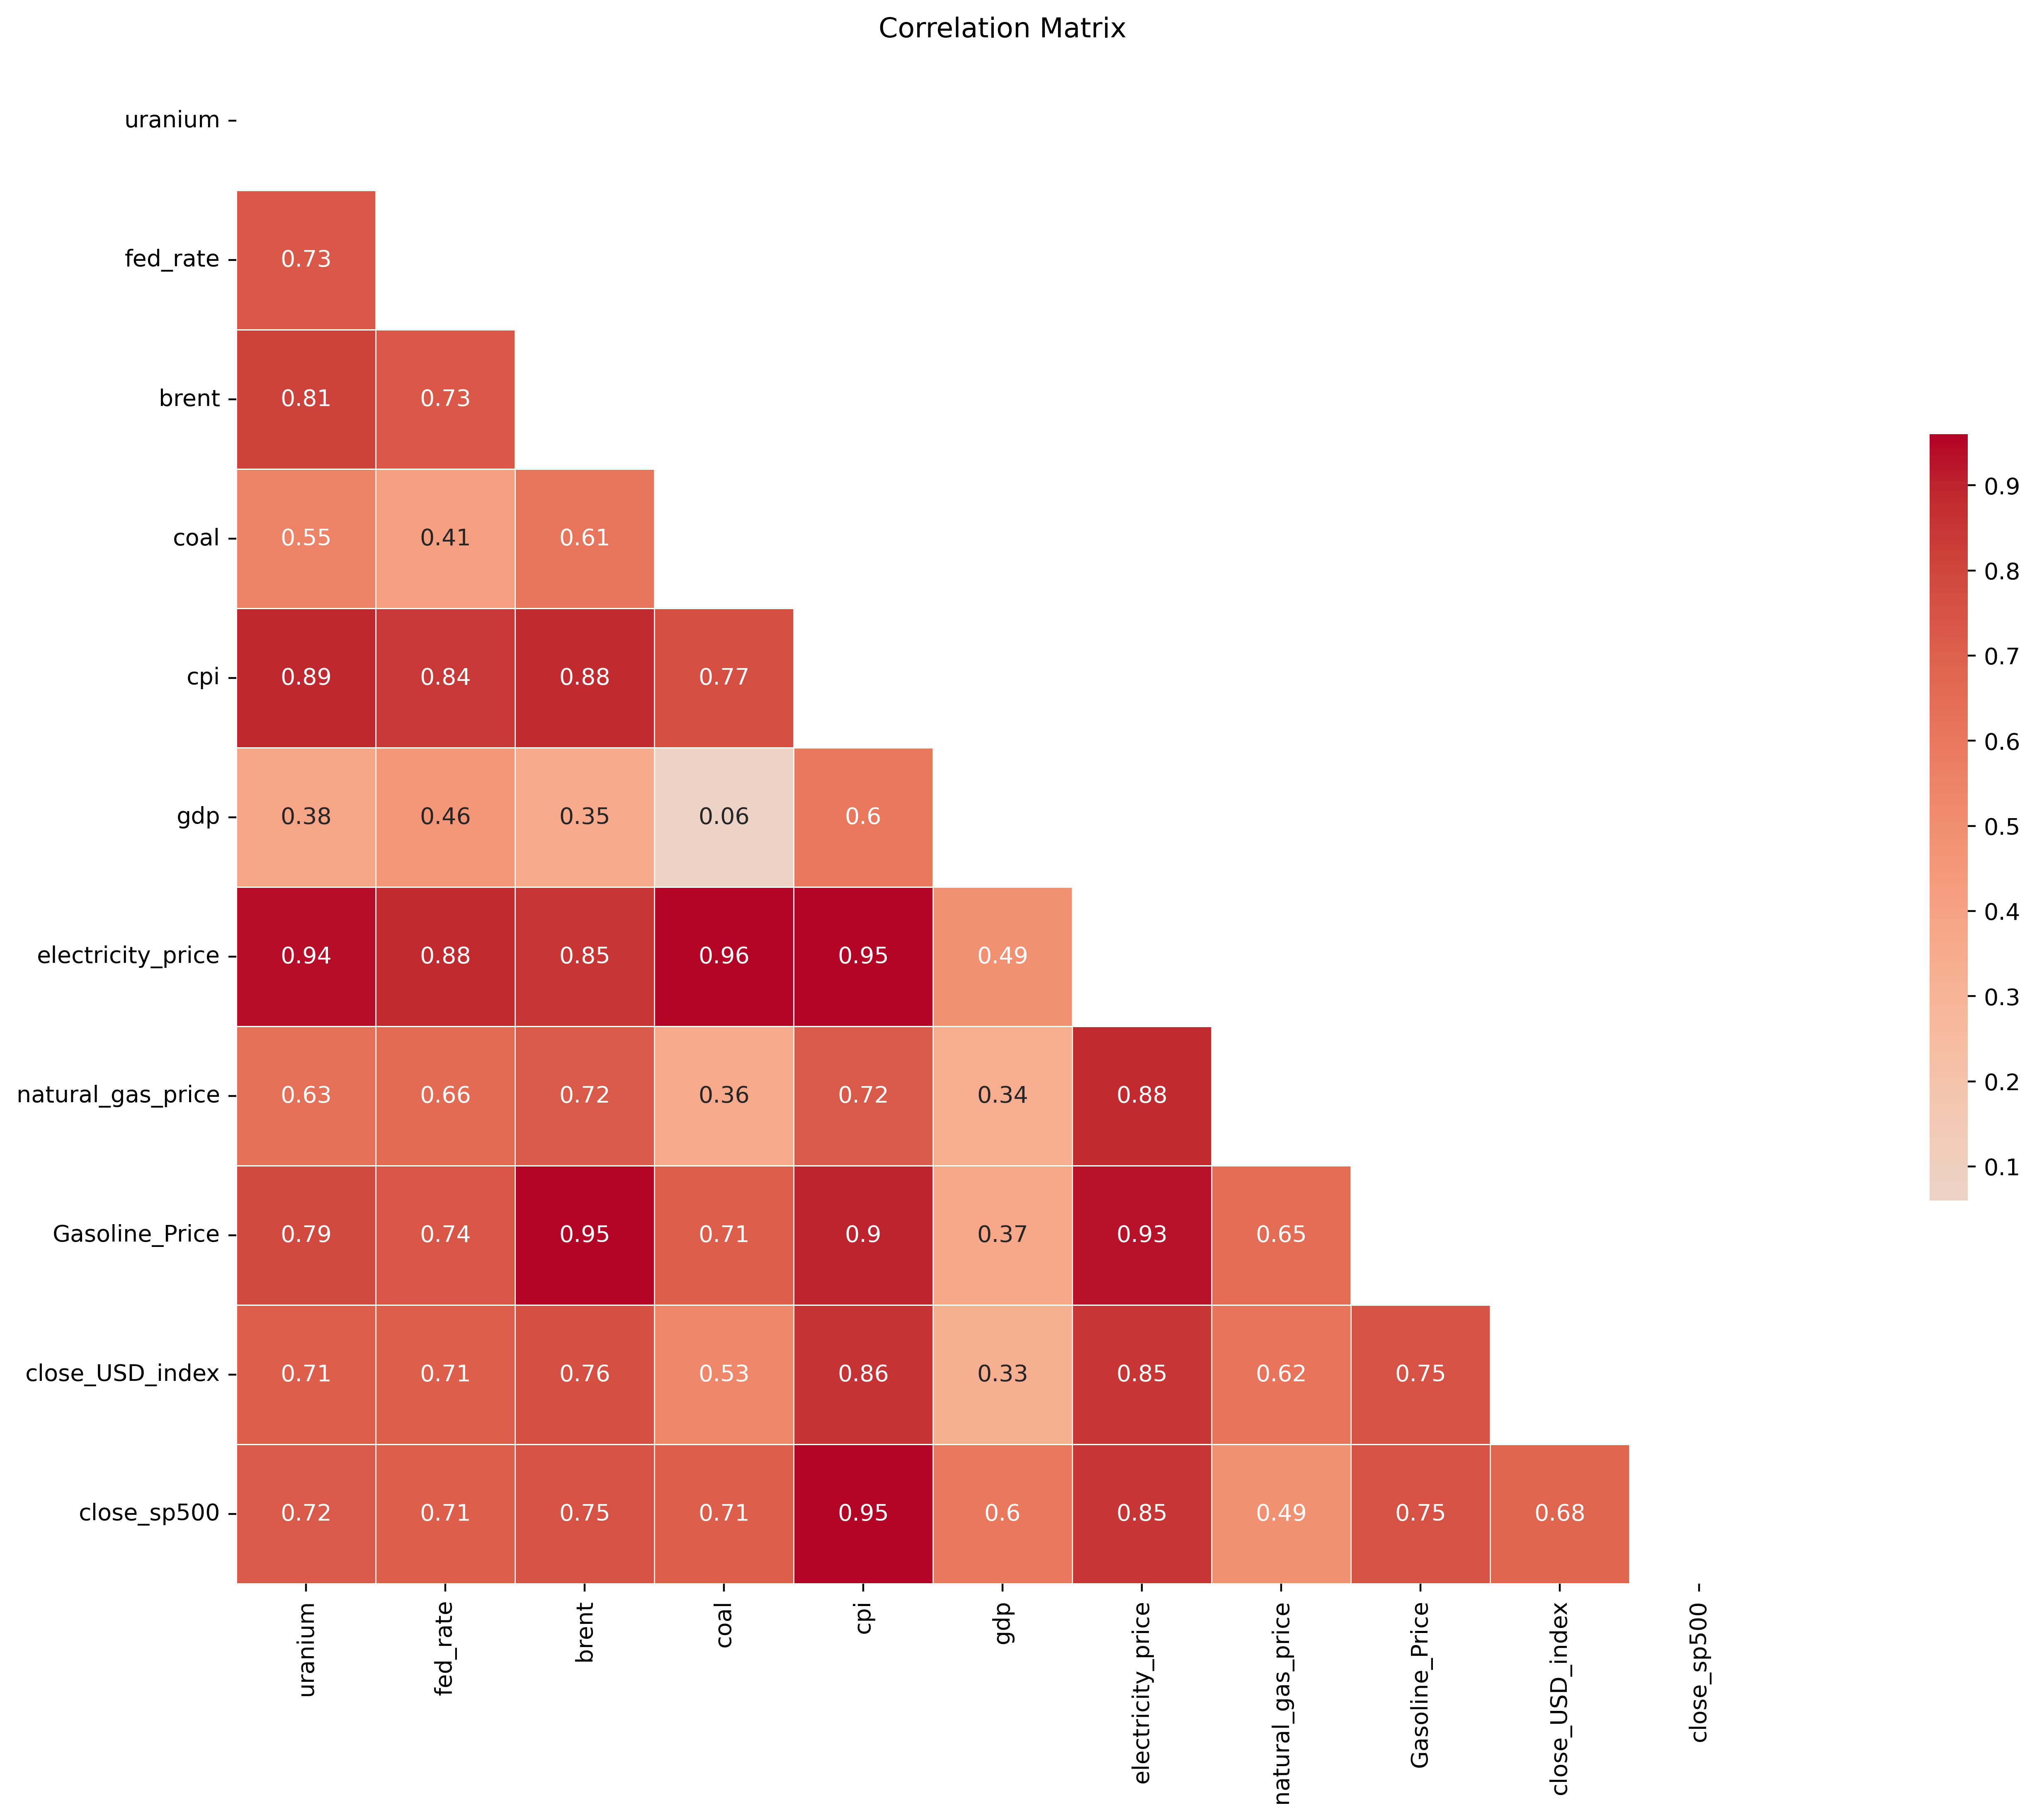

In [13]:
corr_matrix = df_final.copy().phik_matrix()
corr_matrix.round(2)

mask = np.triu(np.ones_like(corr_matrix.round(2), dtype=bool))
f, ax = plt.subplots(figsize=(25, 12), dpi = 400)

sns.heatmap(
    corr_matrix.round(2), 
    center=-0.07, 
    cmap="coolwarm", 
    square=True,
    linewidth=0.5, 
    cbar_kws={"shrink": .5}, 
    annot=True, 
    mask=mask
)
ax.set_title('Correlation Matrix');

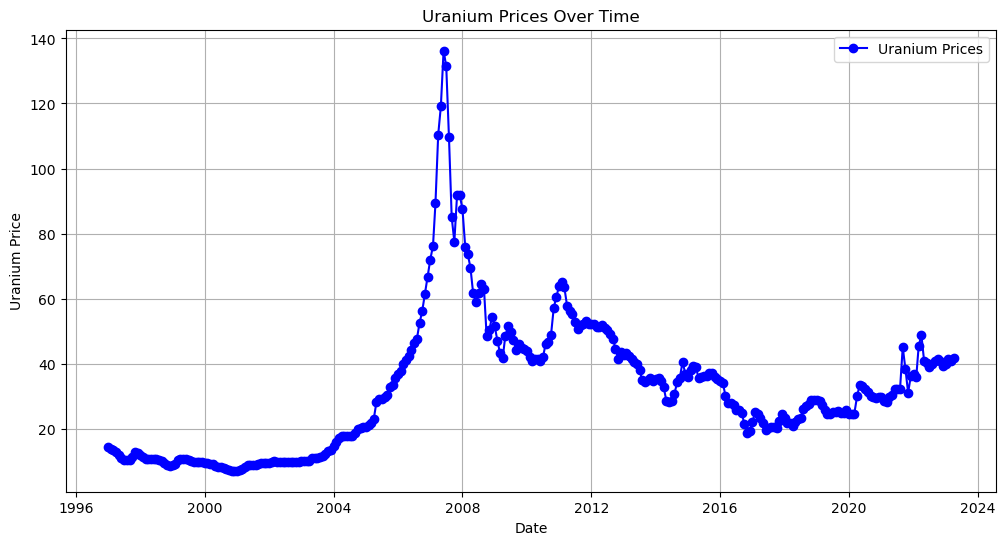

In [14]:
df_final.index = pd.to_datetime(df_final.index)

# Visualize Uranium Prices over time
plt.figure(figsize=(12, 6))
plt.plot(df_final.index, df_final['uranium'], label='Uranium Prices', marker='o', linestyle='-', color='b')
plt.title('Uranium Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Uranium Price')
plt.legend()

# Set x-axis ticks to be the years only with a fixed number of ticks
desired_ticks = 6  # Adjust this based on your preference
plt.locator_params(axis='x', nbins=desired_ticks)

plt.grid(True)
plt.show()

# OLS

In [15]:

df_final.index = pd.to_datetime(df_final.index)

# Create a copy starting from '2009-01-01'
df_new = df_final[df_final.index >= '2009-01-01'].copy()

# Resetting the index to numerical
df_new.reset_index(drop=True, inplace=True)

df_new


,uranium,fed_rate,brent,coal,cpi,gdp,electricity_price,natural_gas_price,Gasoline_Price,close_USD_index,close_sp500
0,51.444444,0.15,43.174545,85.561735,211.933,98.489580,0.126,5.24,1.788,86.000000,825.880005
1,47.000000,0.22,42.910500,80.822679,212.705,98.173207,0.126,4.52,1.923,88.010002,735.090027
2,43.375000,0.18,46.582727,65.452110,212.495,97.945064,0.126,3.96,1.959,85.430000,797.869995
3,41.718750,0.15,50.519091,66.270536,212.709,97.800401,0.125,3.50,2.049,84.610001,872.809998
4,48.555556,0.18,57.501429,67.015038,213.022,97.731591,0.126,3.83,2.266,80.430000,919.140015
...,...,...,...,...,...,...,...,...,...,...,...
167,39.178244,4.10,81.503182,427.686964,298.990,99.828562,0.165,5.53,3.210,103.519997,3839.500000
168,40.063400,4.33,84.081818,404.535204,300.536,99.860089,0.168,3.27,3.339,102.099998,4076.600098
169,41.314371,4.57,83.632500,244.205357,301.648,99.885841,0.168,2.38,3.389,104.870003,3970.149902
170,40.741523,4.65,79.256522,195.999224,301.808,99.906923,0.166,2.31,3.422,102.510002,4109.310059


In [16]:
import statsmodels.api as sm
import statsmodels as sm

In [17]:
df_new.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   uranium            172 non-null    float64
 1   fed_rate           172 non-null    float64
 2   brent              172 non-null    float64
 3   coal               172 non-null    float64
 4   cpi                172 non-null    float64
 5   gdp                172 non-null    float64
 6   electricity_price  172 non-null    object 
 7   natural_gas_price  172 non-null    float64
 8   Gasoline_Price     172 non-null    float64
 9   close_USD_index    172 non-null    float64
 10  close_sp500        172 non-null    float64
dtypes: float64(10), object(1)
memory usage: 14.9+ KB


In [31]:
y = df_new['uranium']

Xt = df_new[['coal','cpi', 'close_USD_index', 'close_sp500']]

In [32]:
model_lm = sm.OLS(y, Xt)
results = model_lm.fit()


summary = results.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                uranium   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                              1213.
Date:                Sun, 19 Nov 2023   Prob (F-statistic):                   9.28e-123
Time:                        19:16:28   Log-Likelihood:                         -577.25
No. Observations:                 172   AIC:                                      1163.
Df Residuals:                     168   BIC:                                      1175.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
coal                0.0411      0.008      5.326      0.000       0.026       0.056
cpi                 0.5113      0.037     13.708      0.000       0.438       0.585
close_USD_index    -0.7315      0.096     -7.646      0.000      -0.920      -0.543
close_sp500        -0.0118      0.001    -17.244      0.000      -0.013      -0.010
==============================================================================
Omnibus:                        1.519   Durbin-Watson:                   0.212
Prob(Omnibus):                  0.468   Jarque-Bera (JB):                1.450
Skew:                           0.121   Prob(JB):                        0.484
Kurtosis:                       2.621   Cond. No.                         494.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
fitted_values = results.fittedvalues


<Axes: ylabel='uranium'>

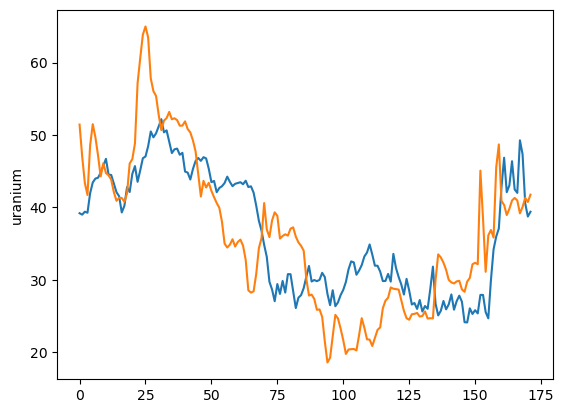

In [34]:
sns.lineplot(data=fitted_values)
sns.lineplot(data=df_new['uranium'])

In [35]:

from sklearn.metrics import mean_squared_error

preds = results.predict(Xt)

print(mean_squared_error(y, fitted_values))
print("RMSE:", mean_squared_error(y, fitted_values) ** 0.5)

48.152979855231
RMSE: 6.939234817703678


In [37]:
X_cols = df_new[['coal', 'cpi', 'close_USD_index', 'close_sp500']].copy()
y_col = df_new['uranium'].copy()
 
 
X_cols.describe()


,coal,cpi,close_USD_index,close_sp500
count,172.000000,172.000000,172.000000,172.000000
mean,117.018409,244.793465,90.032093,2342.533375
std,85.579328,22.222264,9.081048,1048.289685
min,51.382500,211.933000,72.930000,735.090027
25%,72.888555,229.735250,80.972500,1407.997467
50%,92.940360,238.057000,92.535000,2097.905029
75%,114.303758,256.067250,96.994997,2947.927551
max,467.783673,302.918000,112.120003,4766.180176


In [38]:
np.random.seed(42)

X_new = pd.DataFrame(
    {
        "coal": np.random.uniform(100, 180, 12 ),
        'cpi': np.linspace(307, 320, 12),
        'close_USD_index': np.random.uniform(95, 115, 12),
        'close_sp500': np.random.uniform(4400, 4800, 12)
    }
)


X_new

,coal,cpi,close_USD_index,close_sp500
0,129.963210,307.000000,111.648853,4582.427994
1,176.057145,308.181818,99.246782,4714.070385
2,158.559515,309.363636,98.636499,4479.869513
3,147.892679,310.545455,98.668090,4605.693775
4,112.481491,311.727273,101.084845,4636.965828
5,112.479562,312.909091,105.495129,4418.580165
6,104.646689,314.090909,103.638900,4643.017941
7,169.294092,315.272727,100.824583,4468.209649
8,148.089201,316.454545,107.237058,4426.020637
9,156.645806,317.636364,97.789877,4779.554215


In [39]:
y_preds_12 = results.predict(X_new)

In [40]:
y_preds_12

0     26.390083
1     36.402290
2     39.506926
3     38.160113
4     35.171209
5     35.134766
6     34.117854
7     41.506906
8     37.048474
9     40.729586
10    36.761326
11    40.144985
dtype: float64

In [41]:
new_y = pd.concat([df_new['uranium'], y_preds_12], ignore_index=True)

new_y

0      51.444444
1      47.000000
2      43.375000
3      41.718750
4      48.555556
         ...    
179    41.506906
180    37.048474
181    40.729586
182    36.761326
183    40.144985
Length: 184, dtype: float64

<Axes: >

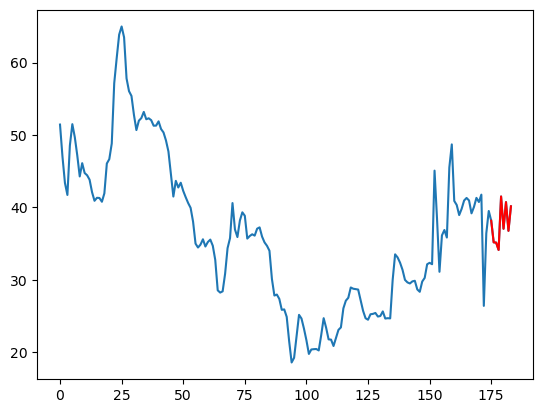

In [42]:
sns.lineplot(data = new_y)
sns.lineplot(data=new_y.loc[175:187], color='red')